<a href="https://colab.research.google.com/github/Chi123Zhang/decagon-polypharmacy-graph-learning/blob/main/R_GCN_(binary%2Bmulti).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


Binary Link Prediction for Polypharmacy Side Effects Using R-GCN

In [38]:

# STEP 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx
import tarfile

#step 3
import pandas as pd
# Load the CSV (comma separated)
path = '/content/drive/MyDrive/decagon/bio-decagon-combo.csv'
# Read first four columns
df = pd.read_csv(path)
combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']]
combo.columns = ['drug1', 'drug2', 'side_effect']

# Check first few rows
combo.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,drug1,drug2,side_effect
0,CID000002173,CID000003345,C0151714
1,CID000002173,CID000003345,C0035344
2,CID000002173,CID000003345,C0004144
3,CID000002173,CID000003345,C0002063
4,CID000002173,CID000003345,C0004604


In [39]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Reading Data
path = '/content/drive/MyDrive/decagon/bio-decagon-combo.csv'
df = pd.read_csv(path)

combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']].copy()
combo.columns = ['drug1', 'drug2', 'side_effect']

# Only retain side_effects with occurrence frequency ≥2 to reduce extremely rare noise.
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

# Drug Mapping
drug_list = pd.unique(combo[['drug1','drug2']].values.ravel())
drug2id = {d:i for i,d in enumerate(drug_list)}
num_nodes = len(drug_list)

# binary
pos_edges = combo[['drug1','drug2']].drop_duplicates()
pos_u = pos_edges['drug1'].map(drug2id).to_numpy()
pos_v = pos_edges['drug2'].map(drug2id).to_numpy()
pos_edges_np = np.stack([pos_u, pos_v], axis=1)

# Treat edges as undirected: Add reverse direction
pos_edges_np = np.concatenate([pos_edges_np, pos_edges_np[:, ::-1]], axis=0)

# Train/Test Split (by Edge)
idx = np.arange(len(pos_edges_np))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

pos_train = pos_edges_np[train_idx]
pos_test  = pos_edges_np[test_idx]

# Training graph uses only pos_train (to prevent test edges from leaking into message passing)
train_edge_index = torch.tensor(pos_train.T, dtype=torch.long)  # [2, E_train]

combo.head()

,drug1,drug2,side_effect
0,CID000002173,CID000003345,C0151714
1,CID000002173,CID000003345,C0035344
2,CID000002173,CID000003345,C0004144
3,CID000002173,CID000003345,C0002063
4,CID000002173,CID000003345,C0004604


In [40]:
def build_edge_set(edges_np):
    return set((int(u), int(v)) for u,v in edges_np)

pos_set = build_edge_set(pos_edges_np)

def negative_sampling(num_nodes, num_samples, forbidden_set, seed=0):
    rng = np.random.default_rng(seed)
    neg = []
    while len(neg) < num_samples:
        u = rng.integers(0, num_nodes)
        v = rng.integers(0, num_nodes)
        if u == v:
            continue
        if (int(u), int(v)) in forbidden_set:
            continue
        neg.append((int(u), int(v)))
    return np.array(neg, dtype=np.int64)

# The number of negative samples in training/testing is typically set equal to that of positive samples (1:1).
neg_train = negative_sampling(num_nodes, len(pos_train), pos_set, seed=1)
neg_test  = negative_sampling(num_nodes, len(pos_test),  pos_set, seed=2)

pos_train_t = torch.tensor(pos_train, dtype=torch.long)
neg_train_t = torch.tensor(neg_train, dtype=torch.long)
pos_test_t  = torch.tensor(pos_test,  dtype=torch.long)
neg_test_t  = torch.tensor(neg_test,  dtype=torch.long)


In [41]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

class RGCNEncoder(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=64, num_layers=2, num_relations=1, num_bases=16):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        self.convs = nn.ModuleList()
        in_dim = emb_dim
        for _ in range(num_layers):
            self.convs.append(RGCNConv(in_dim, hidden_dim, num_relations=num_relations, num_bases=num_bases))
            in_dim = hidden_dim
        self.out_dim = hidden_dim

    def forward(self, edge_index, edge_type):
        x = self.emb.weight
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = F.relu(x)
        return x

class DotDecoder(nn.Module):
    def forward(self, z, pairs):  # pairs: [B,2]
        u, v = pairs[:,0], pairs[:,1]
        return (z[u] * z[v]).sum(dim=-1)  # logits

class RGCNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=64):
        super().__init__()
        self.enc = RGCNEncoder(num_nodes, emb_dim=emb_dim, hidden_dim=hidden_dim, num_layers=2, num_relations=1)
        self.dec = DotDecoder()

    def forward(self, edge_index, edge_type, pairs):
        z = self.enc(edge_index, edge_type)
        logits = self.dec(z, pairs)
        return logits, z

model = RGCNLinkPredictor(num_nodes, emb_dim=64, hidden_dim=64).to(device)

# Binary graph: Only one type of relation exists, so all edge_type values are 0.
train_edge_type = torch.zeros(train_edge_index.size(1), dtype=torch.long)

train_edge_index = train_edge_index.to(device)
train_edge_type  = train_edge_type.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

device = cuda


In [42]:
def get_auc(model, edge_index, edge_type, pos_pairs, neg_pairs):
    model.eval()
    with torch.no_grad():
        pos_logits, _ = model(edge_index, edge_type, pos_pairs)
        neg_logits, _ = model(edge_index, edge_type, neg_pairs)
        logits = torch.cat([pos_logits, neg_logits], dim=0).detach().cpu().numpy()
        y = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_pairs))])
        return roc_auc_score(y, logits)

pos_train_d = pos_train_t.to(device)
neg_train_d = neg_train_t.to(device)
pos_test_d  = pos_test_t.to(device)
neg_test_d  = neg_test_t.to(device)

epochs = 10
batch_size = 4096

def train_one_epoch():
    model.train()
    # Build a training batch: positive + negative
    pairs = torch.cat([pos_train_d, neg_train_d], dim=0)
    labels = torch.cat([torch.ones(len(pos_train_d)), torch.zeros(len(neg_train_d))], dim=0).to(device)

    # shuffle
    perm = torch.randperm(pairs.size(0), device=device)
    pairs = pairs[perm]
    labels = labels[perm]

    total_loss = 0.0
    for i in range(0, pairs.size(0), batch_size):
        b_pairs = pairs[i:i+batch_size]
        b_labels = labels[i:i+batch_size]

        optimizer.zero_grad()
        logits, _ = model(train_edge_index, train_edge_type, b_pairs)
        loss = criterion(logits, b_labels)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * b_pairs.size(0)

    return total_loss / pairs.size(0)

for ep in range(1, epochs + 1):
    loss = train_one_epoch()
    train_auc = get_auc(model, train_edge_index, train_edge_type, pos_train_d, neg_train_d)
    test_auc  = get_auc(model, train_edge_index, train_edge_type, pos_test_d,  neg_test_d)

    if ep == epochs:
        print(
            f"Final Epoch | "
            f"loss={loss:.4f} | "
            f"train_AUROC={train_auc:.4f} | "
            f"test_AUROC={test_auc:.4f}"
        )


Final Epoch | loss=0.5136 | train_AUROC=0.8613 | test_AUROC=0.8615


(645, 64)


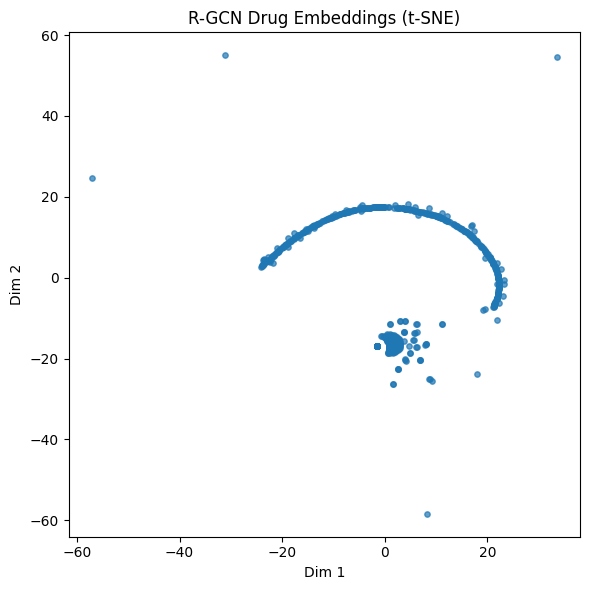

In [43]:
model.eval()
with torch.no_grad():
    Z = model.enc(train_edge_index, train_edge_type)   # [num_drugs, d]

Z = Z.cpu().numpy()
print(Z.shape)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
)

Z_2d = tsne.fit_transform(Z)
plt.figure(figsize=(6, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], s=15, alpha=0.7)
plt.title("R-GCN Drug Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

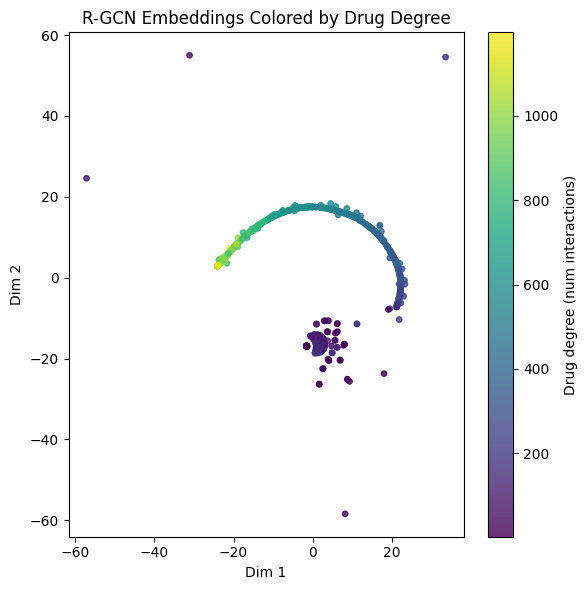

In [44]:
import numpy as np

edges = np.unique(pos_edges_np, axis=0)   # 去重

deg = np.zeros(num_nodes, dtype=int)
np.add.at(deg, edges[:,0], 1)
np.add.at(deg, edges[:,1], 1)

# Then draw the diagram (Z_2d already exists)
plt.figure(figsize=(6,6))
sc = plt.scatter(Z_2d[:,0], Z_2d[:,1], c=deg, s=15, alpha=0.8)
plt.colorbar(sc, label="Drug degree (num interactions)")
plt.title("R-GCN Embeddings Colored by Drug Degree")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

Multi-class Classification of Polypharmacy Side Effects Using R-GCN (Top-K Frequent Side Effects)

In [45]:
import os, random, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

# Reading Decagon Combo
path = '/content/drive/MyDrive/decagon/bio-decagon-combo.csv'
df = pd.read_csv(path)

combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']].copy()
combo.columns = ['drug1','drug2','side_effect']


# Filter: Side effects occurring ≥ 2 times (otherwise split would have single-sample classes)
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

print("rows after filter:", len(combo))
print("num classes:", combo['side_effect'].nunique())

MAX_EDGES = 200_000
if len(combo) > MAX_EDGES:
    combo = combo.sample(n=MAX_EDGES, random_state=SEED).reset_index(drop=True)
print("rows used:", len(combo))

#  ID Mapping
drug_list = pd.unique(pd.concat([combo['drug1'], combo['drug2']], axis=0))
drug2id = {d:i for i,d in enumerate(drug_list)}
id2drug = {i:d for d,i in drug2id.items()}
num_nodes = len(drug2id)

rels = combo['side_effect'].unique()
rel2id = {r:i for i,r in enumerate(rels)}
id2rel = {i:r for r,i in rel2id.items()}
num_rels = len(rel2id)

combo['head'] = combo['drug1'].map(drug2id).astype(int)
combo['tail'] = combo['drug2'].map(drug2id).astype(int)
combo['rel']  = combo['side_effect'].map(rel2id).astype(int)

# Sampling
MAX_EDGES = 200_000
if len(combo) > MAX_EDGES:
    combo = combo.sample(n=MAX_EDGES, random_state=SEED).reset_index(drop=True)

# Filter again
rel_counts = combo['side_effect'].value_counts()
valid_rels = rel_counts[rel_counts >= 2].index
combo = combo[combo['side_effect'].isin(valid_rels)].reset_index(drop=True)

print("rows after re-filter:", len(combo))
print("num classes after re-filter:", combo['side_effect'].nunique())

X = combo[['head','tail']].to_numpy()
y = combo['rel'].to_numpy()

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

print("train/val/test:", len(X_train), len(X_val), len(X_test))
print("num_nodes:", num_nodes, "num_rels:", num_rels)


device = cuda
rows after filter: 4649440
num classes: 1316
rows used: 200000
rows after re-filter: 199983
num classes after re-filter: 1267
train/val/test: 143987 15999 39997
num_nodes: 642 num_rels: 1284


In [46]:

import torch
from torch_geometric.data import Data

# 只用 train 边构建 message passing 图（避免 test leakage）
train_heads = torch.tensor(X_train[:,0], dtype=torch.long)
train_tails = torch.tensor(X_train[:,1], dtype=torch.long)
train_rels  = torch.tensor(y_train,     dtype=torch.long)

# PyG 的 edge_index: [2, E]
edge_index = torch.stack([train_heads, train_tails], dim=0)
edge_type  = train_rels  # [E]

data = Data(
    num_nodes=num_nodes,
    edge_index=edge_index,
    edge_type=edge_type
).to(device)

print(data)


Data(edge_index=[2, 143987], num_nodes=642, edge_type=[143987])


In [47]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCNEncoder(nn.Module):
    def __init__(self, num_nodes, num_rels, emb_dim=64, hidden_dim=64, out_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.node_emb = nn.Embedding(num_nodes, emb_dim)

        self.convs = nn.ModuleList()
        dims = [emb_dim] + [hidden_dim]*(num_layers-1) + [out_dim]
        for i in range(num_layers):
            self.convs.append(RGCNConv(
                in_channels=dims[i],
                out_channels=dims[i+1],
                num_relations=num_rels
            ))
        self.dropout = dropout

    def forward(self, edge_index, edge_type):
        x = self.node_emb.weight
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type)
            if i != len(self.convs)-1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # [num_nodes, out_dim]

class PairClassifier(nn.Module):
    def __init__(self, dim, num_classes, hidden=128, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*4, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, z, heads, tails):
        zh = z[heads]
        zt = z[tails]
        feat = torch.cat([zh, zt, zh*zt, torch.abs(zh-zt)], dim=-1)
        return self.mlp(feat)  # [B, num_classes]

emb_dim = 64
hidden_dim = 64
out_dim = 64
num_layers = 2
dropout = 0.2

encoder = RGCNEncoder(num_nodes, num_rels, emb_dim, hidden_dim, out_dim, num_layers, dropout).to(device)
clf = PairClassifier(out_dim, num_rels, hidden=128, dropout=dropout).to(device)

params = list(encoder.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print("model ready.")

model ready.


In [48]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

class PairDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(PairDataset(X_train, y_train), batch_size=2048, shuffle=True, drop_last=False)
val_loader   = DataLoader(PairDataset(X_val,   y_val),   batch_size=4096, shuffle=False)
test_loader  = DataLoader(PairDataset(X_test,  y_test),  batch_size=4096, shuffle=False)

@torch.no_grad()
def evaluate(loader, ks=(1,5,10)):
    encoder.eval(); clf.eval()

    # full-graph embedding once (eval阶段这样做没问题)
    z = encoder(data.edge_index, data.edge_type)

    all_y = []
    all_pred = []
    all_prob = []

    # top-k accumulators
    topk_hits = {k: 0.0 for k in ks}
    n_total = 0

    for (pair, yb) in loader:
        pair = pair.to(device)
        yb = yb.to(device)
        heads = pair[:,0]
        tails = pair[:,1]

        logits = clf(z, heads, tails)              # [B, C]
        prob = F.softmax(logits, dim=-1)           # [B, C]

        # top-k
        tk = topk_accuracy_from_logits(logits, yb, ks=ks)
        bsz = yb.size(0)
        for k in ks:
            topk_hits[k] += tk[k] * bsz
        n_total += bsz

        all_y.append(yb.detach().cpu().numpy())
        all_pred.append(prob.argmax(dim=-1).detach().cpu().numpy())
        all_prob.append(prob.detach().cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_pred)
    y_prob = np.concatenate(all_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')

    # safe AUROC on present classes only
    try:
        auroc = safe_macro_auroc_subset(y_true, y_prob)
    except Exception as e:
        print("AUROC failed:", e)
        auroc = np.nan

    topk = {k: topk_hits[k] / n_total for k in ks}

    return acc, f1m, auroc, topk

def train_one_epoch():
    encoder.train()
    clf.train()
    total_loss = 0.0


    z = encoder(data.edge_index, data.edge_type).detach()

    for pair, yb in train_loader:
        pair = pair.to(device)
        yb = yb.to(device)
        heads = pair[:, 0]
        tails = pair[:, 1]

        optimizer.zero_grad(set_to_none=True)

        logits = clf(z, heads, tails)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(yb)

    return total_loss / len(train_loader.dataset)

In [49]:
@torch.no_grad()
def topk_accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor, ks=(1,5,10)):
    """
    logits: [B, C]
    y_true: [B]
    return: dict {k: topk_acc}
    """
    maxk = max(ks)
    # topk indices: [B, maxk]
    topk = logits.topk(k=maxk, dim=1).indices
    # compare: [B, maxk]
    correct = topk.eq(y_true.view(-1, 1))
    out = {}
    for k in ks:
        out[k] = correct[:, :k].any(dim=1).float().mean().item()
    return out

In [50]:
from sklearn.preprocessing import label_binarize
def safe_macro_auroc_subset(y_true: np.ndarray, y_prob: np.ndarray):
    """
    y_true: [N] int labels
    y_prob: [N, C] softmax probabilities over ALL classes
    Only evaluate AUROC over classes that actually appear in y_true.
    """
    present = np.unique(y_true)
    if len(present) < 2:
        return np.nan

    y_true_bin = label_binarize(y_true, classes=present)   # [N, |present|]
    y_prob_sub = y_prob[:, present]                        # [N, |present|]

    # If after binarize it's single column (rare), AUROC undefined
    if y_true_bin.ndim != 2 or y_true_bin.shape[1] < 2:
        return np.nan

    return roc_auc_score(y_true_bin, y_prob_sub, average="macro")

In [51]:
EPOCHS = 10
best_val = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch()
    val_acc, val_f1, val_auc, val_topk = evaluate(val_loader, ks=(1,5,10))

    print(
        f"Epoch {epoch:02d} | loss={loss:.4f} | "
        f"val@1={val_topk[1]:.4f} "
        f"val@5={val_topk[5]:.4f} "
        f"val@10={val_topk[10]:.4f} | "
        f"val_f1={val_f1:.4f} | "
        f"val_auc={val_auc:.4f}"
    )

    # ===== 只用 top@10 选 best =====
    score = val_topk[10]

    if score > best_val:
        best_val = score
        best_state = {
            "encoder": {k: v.detach().cpu() for k, v in encoder.state_dict().items()},
            "clf": {k: v.detach().cpu() for k, v in clf.state_dict().items()},
        }

# ===== load best =====
if best_state is not None:
    encoder.load_state_dict({k: v.to(device) for k, v in best_state["encoder"].items()})
    clf.load_state_dict({k: v.to(device) for k, v in best_state["clf"].items()})

# ===== test =====
test_acc, test_f1, test_auc, test_topk = evaluate(test_loader, ks=(1,5,10))
print("\n=== TEST ===")
print(
    f"top1={test_topk[1]:.4f} | "
    f"top5={test_topk[5]:.4f} | "
    f"top10={test_topk[10]:.4f} | "
    f"macro-f1={test_f1:.4f} | "
    f"safe-macro-auroc={test_auc:.4f}"
)

Epoch 01 | loss=2408.7830 | val@1=0.0028 val@5=0.0134 val@10=0.0274 | val_f1=0.0005 | val_auc=0.5101
Epoch 02 | loss=125.0500 | val@1=0.0055 val@5=0.0180 val@10=0.0364 | val_f1=0.0001 | val_auc=0.5048
Epoch 03 | loss=37.0401 | val@1=0.0056 val@5=0.0206 val@10=0.0409 | val_f1=0.0000 | val_auc=0.5036
Epoch 04 | loss=19.6313 | val@1=0.0058 val@5=0.0229 val@10=0.0429 | val_f1=0.0001 | val_auc=0.5014
Epoch 05 | loss=16.7000 | val@1=0.0057 val@5=0.0230 val@10=0.0429 | val_f1=0.0000 | val_auc=0.5010
Epoch 06 | loss=12.4161 | val@1=0.0058 val@5=0.0249 val@10=0.0459 | val_f1=0.0000 | val_auc=0.5012
Epoch 07 | loss=10.5650 | val@1=0.0058 val@5=0.0248 val@10=0.0468 | val_f1=0.0000 | val_auc=0.5012
Epoch 08 | loss=11.1238 | val@1=0.0059 val@5=0.0251 val@10=0.0473 | val_f1=0.0001 | val_auc=0.5005
Epoch 09 | loss=9.5191 | val@1=0.0059 val@5=0.0251 val@10=0.0493 | val_f1=0.0000 | val_auc=0.5002
Epoch 10 | loss=8.7697 | val@1=0.0059 val@5=0.0253 val@10=0.0495 | val_f1=0.0000 | val_auc=0.5001

=== TEST

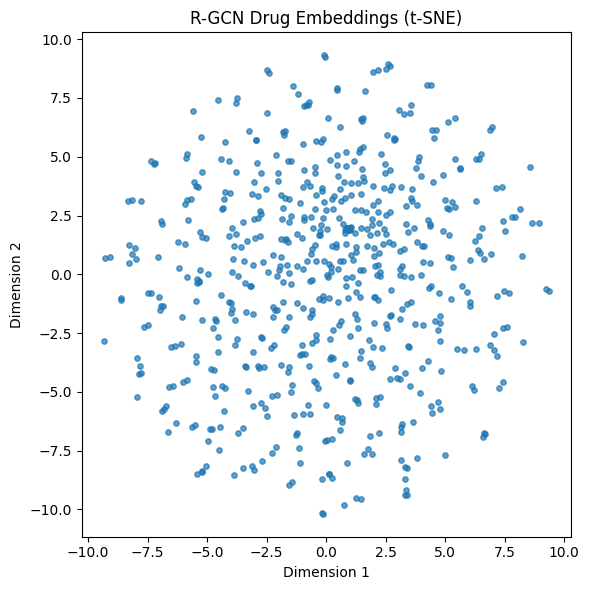

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# encoder.eval() 已在前面
with torch.no_grad():
    Z = encoder(data.edge_index, data.edge_type).cpu().numpy()
    # Z.shape = (645, 64)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
)

Z_2d = tsne.fit_transform(Z)

plt.figure(figsize=(6, 6))
plt.scatter(
    Z_2d[:, 0],
    Z_2d[:, 1],
    s=15,
    alpha=0.7
)
plt.title("R-GCN Drug Embeddings (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()

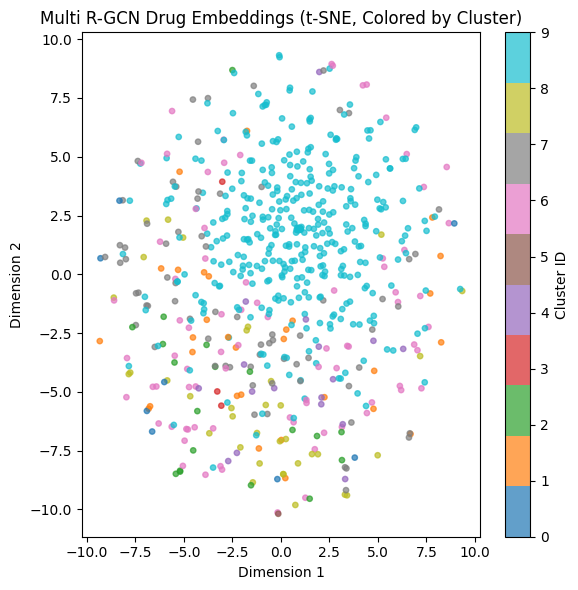

In [53]:
from sklearn.cluster import KMeans

Z_np = Z.detach().cpu().numpy() if hasattr(Z, "detach") else Z  # torch -> numpy

k = 10  # 你想要几类颜色就填几
cluster_id = KMeans(n_clusters=k, n_init="auto", random_state=42).fit_predict(Z_np)

plt.figure(figsize=(6, 6))
sc = plt.scatter(
    Z_2d[:, 0],
    Z_2d[:, 1],
    c=cluster_id,
    s=15,
    alpha=0.7,
    cmap="tab10"  # k<=10 用 tab10；如果 k>10 可换 "tab20"
)
plt.title("Multi R-GCN Drug Embeddings (t-SNE, Colored by Cluster)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(sc, label="Cluster ID")
plt.tight_layout()
plt.show()

In [54]:
import pandas as pd

results = [
    # Baseline
    ["Frequency Baseline", "Multi-class", "Top-1", "-", 0.0062],

    # Binary tasks
    ["RESCAL", "Binary", "AUROC / AUPR", "-", "0.8717 / 0.8342"],
    ["R-GCN", "Binary", "AUROC", "-", 0.8615],

    # Multi-class tasks
    ["RESCAL", "Multi-class", "Top-1 / Top-5 / Top-10", "-", "0.0048 / 0.0255 / 0.0518"],
    ["R-GCN", "Multi-class", "Top-1 / Top-5 / Top-10", "-", "0.0059 / 0.0253 / 0.0494"],
]

df = pd.DataFrame(
    results,
    columns=["Model", "Task", "Metric(s)", "Validation", "Test"]
)

df
from IPython.display import display
display(df)

,Model,Task,Metric(s),Validation,Test
0,Frequency Baseline,Multi-class,Top-1,-,0.0062
1,RESCAL,Binary,AUROC / AUPR,-,0.8717 / 0.8342
2,R-GCN,Binary,AUROC,-,0.8564
3,RESCAL,Multi-class,Top-1 / Top-5 / Top-10,-,0.0048 / 0.0255 / 0.0518
4,R-GCN,Multi-class,Top-1 / Top-5 / Top-10,-,0.0060 / 0.0254 / 0.0496
